<a href="https://colab.research.google.com/github/Luke-Williams-01/Luke-Williams-01/blob/main/ICRARproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import integrate
from scipy import stats, interpolate
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits

In [2]:
! wget -q https://xgass.icrar.org/assets/data/xGASS_representative_sample.ascii

In [3]:
# Loading the xGASS dataset with specific columns selected
xGASStb= np.loadtxt('xGASS_representative_sample.ascii', dtype = 'float', usecols=[8,9,10,16,18,1,23,24,26,27,31,32], unpack= 'true')
# Loading the specfic columns with flags as separate arrays
HIsrc, HI_FLAG = np.loadtxt('xGASS_representative_sample.ascii', dtype = 'float', usecols=[26,27], unpack= 'true')
# Removing data with an index that falls into the conditions HI_FLAG >1 or HI_FLAG <90
xGASSRd = np.delete(xGASStb, np.where((HI_FLAG > 1) & (HI_FLAG < 90)), axis = 1)
xGASST = xGASSRd.T

# Assigning the 1d arrays to the correct column of data
zSDSS = xGASST[:,0]
Dlum = xGASST[:,1]
lgMstar = xGASST[:,2]
petro90r = xGASST[:,3]
lgmust = xGASST[:,4]
lgSFR_tot_median = xGASST[:,5]
SFR_best = xGASST[:,6]
SFRerr_best = xGASST[:,7]
HIsrc = xGASST[:,8]
HI_FLAG = xGASST[:,9]
lgMHI = xGASST[:,10]
lgGF = xGASST[:,11]

In [4]:
# Finding all the rows in the xGASS data with HIsrc < 4, if HIsrc = 4, no detection of HI
# Subtracting no HI detection
# All HI-detected galaxy properties below
HIndet = np.where(HIsrc >= 4)[0]

zSDSS1 = np.delete(zSDSS, (HIndet))
Dlum1 = np.delete(Dlum, (HIndet))
lgMstar1 = np.delete(lgMstar, (HIndet))
petro90r1 = np.delete(petro90r, (HIndet))
lgmust1 = np.delete(lgmust, (HIndet))
lgSFR_tot_median1 = np.delete(lgSFR_tot_median, (HIndet))
SFR_best1 = np.delete(SFR_best, (HIndet))
lgSFR1 = np.log10(SFR_best1)
SFRerr_best1 = np.delete(SFRerr_best, (HIndet))
HIsrc1 = np.delete(HIsrc, (HIndet))
HI_FLAG1 = np.delete(HI_FLAG, (HIndet))
lgMHI1 = np.delete(lgMHI, (HIndet))
lgGF1 = np.delete(lgGF, (HIndet))

# Subtracting HI detection
# All no-HI-detected galaxies below
HIdet = np.where(HIsrc < 4)[0]

zSDSS2 = np.delete(zSDSS, (HIdet))
Dlum2 = np.delete(Dlum, (HIdet))
lgMstar2 = np.delete(lgMstar, (HIdet))
petro90r2 = np.delete(petro90r, (HIdet))
lgmust2 = np.delete(lgmust, (HIdet))
lgSFR_tot_median2 = np.delete(lgSFR_tot_median, (HIdet))
SFR_best2 = np.delete(SFR_best, (HIdet))
SFRerr_best2 = np.delete(SFRerr_best, (HIdet))
HIsrc2 = np.delete(HIsrc, (HIdet))
HI_FLAG2 = np.delete(HI_FLAG, (HIdet))
lgMHI2 = np.delete(lgMHI, (HIdet))
lgGF2 = np.delete(lgGF, (HIdet))

# The bottom two prints should sum to the top print statement
print(len(lgMstar))
print(len(lgMstar1))
print(len(lgMstar2))

# IMPORTANT
# Usually a 1, a or det at the end of a variable name mean it relates to an array where HI was detected
# Usually a 2, b or ndet at the end of a variable name mean it relates to an array where no HI was detected
# A lg in a variable name means that the array has been run through the np.log10() operation
# A p or n at the front of a variable means that it is the positive or negative bound of an error calculation

1066
691
375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


In [5]:
# Finding the running median of the HI detections
# Arrays for the bins
bins = np.linspace(9, 12, 25)
bins2 = np.linspace(-1.25, 1, 25)

# Array of zeroes to store the median of each bin
mHIa = np.zeros(len(bins))
median1 = np.zeros(len(bins))
MAD1 = np.zeros(len(bins))

mHIb = np.zeros(len(bins2))
median2 = np.zeros(len(bins2))
MAD2 = np.zeros(len(bins2))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins) -1):
  # Median and MAD for HI of galaxies against stellar mass
  median1[i] = np.median(lgMHI1[np.where((lgMstar1 >= bins[i]) & (lgMstar1 <= bins[i+1]))])
  MAD1[i] = stats.median_absolute_deviation(lgMHI1[np.where((lgMstar1 >= bins[i]) & (lgMstar1 <= bins[i+1]))])
  mHIa[i] = median1[i]

for i in range (len(bins2) -1):
  # Median and MAD for HI of galaxies against SFR
  median2[i] = np.median(lgMHI1[np.where((lgSFR1 >= bins2[i]) & (lgSFR1 <= bins2[i+1]))])
  MAD2[i] = stats.median_absolute_deviation(lgMHI1[np.where((lgSFR1 >= bins2[i]) & (lgSFR1 <= bins2[i+1]))])
  mHIb[i] = median2[i]

# Working out the upper and lower bounds of the median absolute deviation
pMAD1 = mHIa + MAD1
nMAD1 = mHIa - MAD1
pMAD2 = mHIb + MAD2
nMAD2 = mHIb - MAD2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


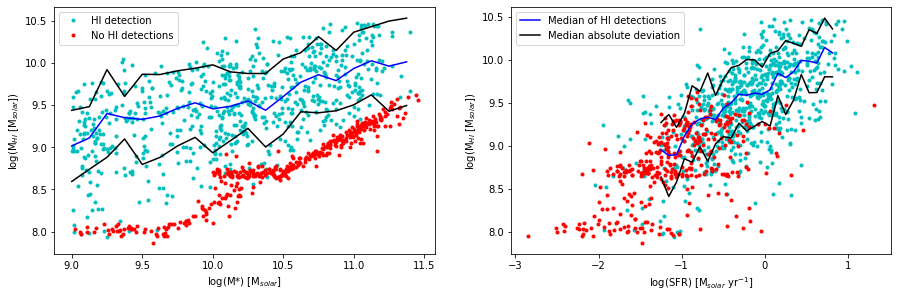

In [6]:
# Global HI mass and HI mass contained in the optical regions with median lines
plt.figure(figsize = (15,10))

plt.subplot(221)
plt.plot(lgMstar1, lgMHI1, 'c.', label= 'HI detection')
plt.plot(lgMstar2, lgMHI2, 'r.', label= 'No HI detections')
plt.plot(bins[:-2], mHIa[:-2], 'b-')
plt.plot(bins[:-2], pMAD1[:-2], 'k-')
plt.plot(bins[:-2], nMAD1[:-2], 'k-')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])')
plt.legend(loc='upper left');

plt.subplot(222)
plt.plot(np.log10(SFR_best1), lgMHI1, 'c.')
plt.plot(np.log10(SFR_best2), lgMHI2, 'r.')
plt.plot(bins2[:-2], mHIb[:-2], 'b-', label = 'Median of HI detections')
plt.plot(bins2[:-2], pMAD2[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(bins2[:-2], nMAD2[:-2], 'k-')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])')
plt.legend(loc='upper left');

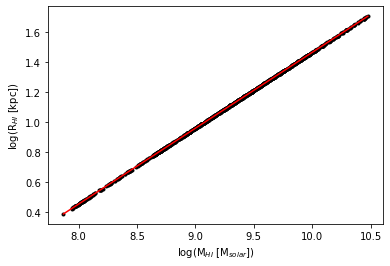

In [7]:
# DHI- MHI relation
lgDHI = 0.506*lgMHI - 3.293
MHI = 10**lgMHI
DHI = 10**lgDHI
RHI = 0.5*DHI
# For HI detections
lgDHI1 = 0.506*lgMHI1 - 3.293
MHI1 = 10**lgMHI1
DHI1 = 10**lgDHI1
RHI1 = 0.5*DHI1
# For no HI detection
lgDHI2 = 0.506*lgMHI2 - 3.293
MHI2 = 10**lgMHI2
DHI2 = 10**lgDHI2
RHI2 = 0.5*DHI2

# Plotting the R(HI)-M(HI) relation
plt.figure()
plt.plot(np.log10(MHI), np.log10(RHI), 'k.')
plt.ylabel('log(R$_{HI}$ [kpc])')
plt.xlabel('log(M$_{HI}$ [M$_{solar}$])')

# Fitting a line to the RHI-MHI relation
x = np.log10(MHI)
p = np.linspace(min(x), max(x), 100)
y = np.log10(RHI)
def linfun(x, m, c): 
    return m*x + c
p0 = np.array([])
popt, pcov = curve_fit(linfun, x, y)
plt.plot(p, linfun(p, *popt), 'r');

-0.9639211636046359
-1.2288723228732537


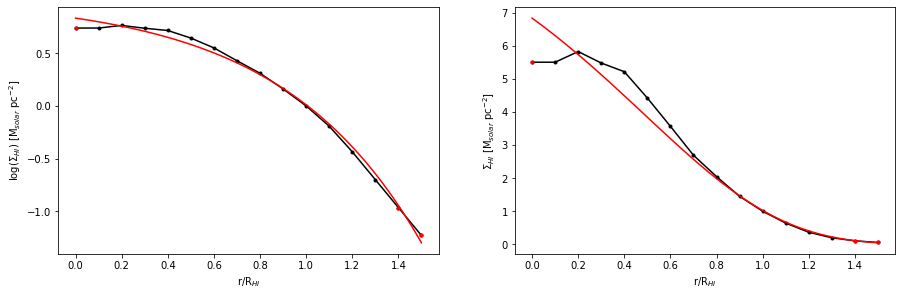

In [8]:
# Need to create a median HI profile of galaxies- (data from Wang et al 2020)
rrHI=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3])
SigHI=np.array([5.50455,5.82575,5.47971,5.21774,4.42226,3.56687,2.69376,2.04850,1.45364,1.00281,0.643707,0.368113,0.2])
lgSigHI = np.log10(SigHI)

# This data has no 0 point and some of the xGASS samples will extend further than the 1.3 r/RHI in the rrHI array, out to 1.5
# Therefore the following will linearly extrapolate:
# Back to the zero-point
x1 = np.flip(rrHI)
y1 = lgSigHI
f1 = interpolate.interp1d(x1, y1, fill_value = "extrapolate")
zpoint = f1(max(x1))
# Forward to 1.5r/RHI
x2 = rrHI
y2 = y1
f2 = interpolate.interp1d(x2, y2, fill_value = "extrapolate")
z1point = f2(1.4)
z2point = f2(1.5)

# New arrays to fit the surface density profile to
newrrHI = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5])
newSigHI=np.array([(10**zpoint),5.50455,5.82575,5.47971,5.21774,4.42226,3.56687,2.69376,2.04850,1.45364,1.00281,0.643707,0.368113,0.2,(10**z1point),(10**z2point)])
newlgSigHI = np.log10(newSigHI)

# Fitting a curve to the extrapolated data
x = newrrHI
p = np.linspace(0, max(newrrHI), 100)
y = newlgSigHI
def curvefun(x, a, b, c, d): 
    return (-a*np.exp((x*b)- c) + d)
p0 = np.array([1,1,1,1])
popt, pcov = curve_fit(curvefun, x, y, p0)

# Plotting the median HI profile using Wang 2020 data
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(newrrHI, newlgSigHI, 'k.-')
plt.xlabel('r/R$_{HI}$')
plt.ylabel('log(Σ$_{HI}$) [M$_{solar}$ pc$^{-2}$]')
plt.plot(p, curvefun(p, *popt), 'r-')
plt.plot(0, zpoint, 'r.')
plt.plot(1.4, z1point, 'r.')
plt.plot(1.5, z2point, 'r.');

plt.subplot(222)
plt.plot(newrrHI, newSigHI, 'k.-')
plt.xlabel('r/R$_{HI}$')
plt.ylabel('Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$]')
plt.plot(p, 10**curvefun(p, *popt), 'r-')
plt.plot(0, 10**zpoint, 'r.')
plt.plot(1.4, 10**z1point, 'r.')
plt.plot(1.5, 10**z2point, 'r.');

print(z1point)
print(z2point)

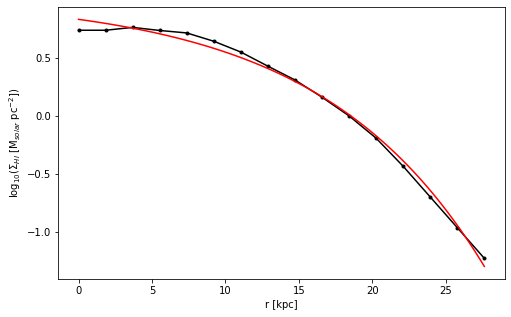

In [9]:
# Each galaxy from the xGASS representative sample can be assumed to follow the same surface density profile as modelled previously
# Rescaling the x-axis by multiplying r/RHI by the 'i'th value in the RHI array determined from the mass relation
# In this case multiplying the r/RHI in the mass relation by the value of RHI for the first galaxy

# Rescaling the curvefitting routine to use the rescaled x-axis
x = newrrHI*RHI[0]
p = np.linspace(0, max((newrrHI*RHI[0])), 100)
y = newlgSigHI
def curvefun(x, a, b, c, d): 
    return (-a*np.exp((x*b)- c) + d)
p0 = np.array([1,1,1,1])
popt, pcov = curve_fit(curvefun, x, y, p0)

# Plotting the surface-density profile for the first galaxy in xGASS
plt.figure(figsize = (8,5))
plt.plot(newrrHI*RHI[0], newlgSigHI, 'k.-')
plt.plot(p, curvefun(p, *popt), 'r-')
plt.xlabel('r [kpc]')
plt.ylabel('log$_{10}$(Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$])');

In [10]:
# To compare the predicted global HI mass to the measured global HI mass we need to integrate under the surface-density profile
# This will be run for all of the galaxies and then the expected global HI mass can be plotted against the measured global HI mass
# The less scatter present in this relation the more accurate the process to determine the HI mass outside the optical region will be
ScaleR0 = newrrHI*RHI[0]
SclR0pc = ScaleR0*1000
SclR0pc2 = np.pi*((SclR0pc)**2)
Sd = 10**newlgSigHI

# Computing the integration via the trapezium method:
x_arr0 = SclR0pc2
y_arr0 = Sd
dx0 = (x_arr0[15] - x_arr0[0]) / len(x_arr0)
areas0 = np.trapz(y_arr0[0:15], x_arr0[0:15], dx = dx0)
mHIpred0 = areas0
''' Alternate trapezium method
def trapezoidal(x,y):
  h = (x[15] - x[0]) / len(x)
  return 0.5*h*((y[0] + y[15]) + 2*np.sum(y[1:14]))
area  = trapezoidal(x_arr0, y_arr0)
'''
print(np.log10(mHIpred0))
print(lgMHI[0])

9.565249650015422
9.603


In [11]:
# Loop the process of rescaling, creating the surface-density profile and computing the integration for all galaxies
# Creating arrays of zeroes to store output data
rrl = len(newrrHI)
Rl = len(RHI)
ScaleR = np.zeros(rrl)
areas = np.zeros(Rl)
MHIpred = np.zeros(Rl)

for i in range(Rl):

  # Rescaling x-axis
  # Takes r/RHI and multiplies by the HI radius for each galaxy
  ScaleR = newrrHI*RHI[i]
  # Converts from  kpc to pc
  SclRpc = ScaleR*1000
  # Approximate each galaxy HI as a flat disk, the area of a circle with radius r [pc]
  SclRpc2 = np.pi*((SclRpc)**2)

  # Rescaling the y-axis
  # Removing the log10 from the surface density
  Sd = 10**newlgSigHI
  
  # Trapezoidal integration
  x_arr = SclRpc2
  y_arr = Sd
  dx = (x_arr[15] - x_arr[0]) / len(x_arr[0:15])
  areas[i] = np.trapz(y_arr[0:15], x_arr[0:15], dx = dx)
  MHIpred[i] = areas[i]

Gradient:  0.9350597287724917 +/- 0.0001814887947998561


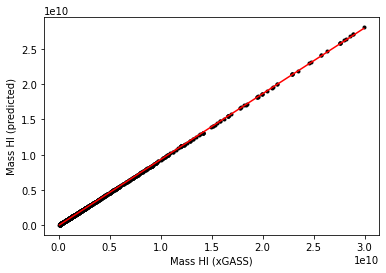

In [12]:
# Comparing how well the total predicted HI mass compares to the total HI mass from xGASS
MassHI = 10**lgMHI
MassHIpred = MHIpred
# Fitting a line to the MHI(predicted) - MHI(xGASS) relation
x = MassHI
p = np.linspace(min(x), max(x), 100)
y = MHIpred
def linfun(x, m, c): 
    return m*x + c
p0 = np.array([])
popt, pcov = curve_fit(linfun, x, y)
# Plotting
plt.plot(MassHI, MassHIpred, 'k.')
plt.xlabel('Mass HI (xGASS)')
plt.ylabel('Mass HI (predicted)')
plt.plot(p, linfun(p, *popt), 'r')
print ('Gradient: ', popt[0], '+/-', np.sqrt(pcov.diagonal()[0])) ;

In [13]:
# Converting the petrosian flux in the r band from arcsec to parsec:
# Using the astropy cosmology module
# Assuming the following cosmology
cosmology = FlatLambdaCDM(H0 = 70, Om0 = 0.3, Tcmb0 = 2.273)
# Converting the data, where .arcsec_per_kpc_proper is the equation of proper distance, using the redshift of the galaxies
arckpc1 = cosmology.arcsec_per_kpc_proper(zSDSS1)
rkpc = petro90r1/arckpc1
print(rkpc[0:11])
print(max(rkpc))

[7.5571206  5.81212757 5.89997901 5.87567526 6.2679055  5.22446477
 9.07191769 4.99415005 5.77196407 8.82255849 5.25805979] kpc / arcsec
19.912857410882232 kpc / arcsec


In [14]:
# To estimate the HI mass inside the optical region of the galaxy a radius is selected that lies on the x-axis for the surface density relation plot
# This radius to 1.5x the radius of the HI region for a given galaxy is then integrated over, this gives the HI mass outside the optical region of the galaxy
# The optical region of the galaxy can be defined in various ways:

# 1) The region that encloses 90% of the optical light (petrosian flux 90% in the r-band)
# Using the optical region as the radius that encloses 90% of the flux in the optical band, we use the equations:
# Angular diameter distance of a galaxy at redshift z:
# DA(z) = DL(z)/(1+z)^2
# Definition of angular diameter distance:
# Theta = size(l)/DA(z)
# Combining these to an expression of the size of a galaxy in kpc, will allow the conversion of the petrosian 90 r band data from units of arcsec to parsec
# This then allows for the calculation of r90 in kpc and the scaling to find the surface density for each galaxy, using the profile estabilished above
# Function:
def arcpc(z, theta, Dlumin):
  arcrad = ((2*np.pi)/360) * (1/3600)
  return (Dlumin* arcrad * theta) / ((1+z)**2)

Rkpc = arcpc(zSDSS, petro90r, Dlum) * 1000
Rkpc1 = arcpc(zSDSS1, petro90r1, Dlum1) * 1000
Rkpc2 = arcpc(zSDSS2, petro90r2, Dlum2) * 1000

# Normalising the converted r band petrosian flux by dividing by RHI
rnorm = (Rkpc) / RHI
rnorm1 = (Rkpc1) / RHI1
rnorm2 = (Rkpc2) / RHI2

# To recover the x-axis with units of kpc we multiply the r/RHI by RHI
r = rnorm * RHI
r1 = rnorm1 * RHI1
r2 = rnorm2 * RHI2

newlen = len(np.where(r1 > 0 )[0]) + len(np.where(r2 > 0)[0])
print(Rkpc[0:11])
print(rnorm[0:11] )

[7.55527428 7.07609468 5.81247389 4.43679769 5.90204885 4.12155789
 5.87477124 6.26823996 5.22385812 5.62932816 8.63572457]
[0.41035736 1.05046994 0.47965283 0.68208676 0.40139577 1.52885888
 0.69165092 0.42234525 0.47374361 0.72496086 0.86368381]


In [15]:
# Integrating under the surface density profile with a given r(90) optical radius
# R(90) was converted from arcsec to kpc and can be converted and rescaled the same as the x-axis from previous
ScaleR0 = newrrHI*RHI[0]
SclR0pc = ScaleR0*1000
SclR0pc2 = np.pi*((SclR0pc)**2)
Sd = 10**newlgSigHI
R90pc = Rkpc[0]*1000 # <---- REMEMBER THIS WILL CHANGE WITH 'i' LIKE RHI[i]
R90pc20 = np.pi*((R90pc)**2)

# Finding the y-coordinate of R90pc2(0) via interpolation for the first galaxy
polate = interpolate.interp1d(SclR0pc2, Sd, fill_value = 'extrapolate')
newy = polate(R90pc20)
print(R90pc20)
print(SclR0pc2)
print(newy)
print(Sd)

179328924.3469587
[0.00000000e+00 1.06494182e+07 4.25976727e+07 9.58447637e+07
 1.70390691e+08 2.66235455e+08 3.83379055e+08 5.21821491e+08
 6.81562764e+08 8.62602873e+08 1.06494182e+09 1.28857960e+09
 1.53351622e+09 1.79975167e+09 2.08728596e+09 2.39611909e+09]
5.143555603981005
[5.50455    5.50455    5.82575    5.47971    5.21774    4.42226
 3.56687    2.69376    2.0485     1.45364    1.00281    0.643707
 0.368113   0.2        0.10866229 0.05903746]


In [16]:
# Computing the integration via the trapezium method:
# Placing r90 x-coordinate inside the array of the preexisting x-coordinate array
placerx = np.append(SclR0pc2, R90pc20)
x_sort = np.sort(placerx)
x_arr = x_sort[np.where(x_sort >= R90pc20)[0]]
print(x_arr)
# Placing r90 y-coordinate inside the array of the preexisting y-coordinate array
y_arr0 = Sd
placery = np.append(y_arr0, newy)
y_sort = np.sort(placery)
y_insort = y_sort[::-1]
y_arr = y_insort[np.where(x_sort >= R90pc20)[0]]
print(y_arr)

# Integrating
dx0 = (x_arr[-1] - x_arr[0]) / len(x_arr)
areasOUT = np.trapz(y_arr[0:-1], x_arr[0:-1], dx = dx0)
MHIpredout = areasOUT

print(MHIpredout)
print(10**lgMHI[0])

[1.79328924e+08 2.66235455e+08 3.83379055e+08 5.21821491e+08
 6.81562764e+08 8.62602873e+08 1.06494182e+09 1.28857960e+09
 1.53351622e+09 1.79975167e+09 2.08728596e+09 2.39611909e+09]
[5.1435556  4.42226    3.56687    2.69376    2.0485     1.45364
 1.00281    0.643707   0.368113   0.2        0.10866229 0.05903746]
2689300057.419604
4008667176.273026


In [17]:
# Process for the first galaxy returns resonable answers for the mass of HI (predicted) outside the defined optical radius
# The mass HI (predicted, out) can be looped over all galaxies:
Rl = len(RHI)
areasOUT = np.zeros(Rl)
MHIpredout = np.zeros(Rl)

for i in range(Rl):

  # Rescaling x-axis
  # Takes r/RHI and multiplies by the HI radius for each galaxy
  ScaleR = newrrHI*RHI[i]
  # Converts from  kpc to pc
  SclRpc = ScaleR*1000
  # Approximate each galaxy HI as a flat disk, the area of a circle with radius r [pc]
  SclRpc2 = np.pi*((SclRpc)**2)

  # Rescaling the y-axis
  # Removing the log10 from the surface density
  Sd = 10**newlgSigHI

  # Radius of the optical region of a given galaxy, contains 90% flux in the r-band
  R90pc = Rkpc[i]*1000 
  R90pc2 = np.pi*((R90pc)**2)

  check = np.where(R90pc2 > SclR0pc2[-1])

  # Finding the y-coordinate of R90pc2 for each galaxy via interpolation
  polate = interpolate.interp1d(SclRpc2, Sd, fill_value = 'extrapolate')
  newy = polate(R90pc2)

  # Placing r90 x-coordinate inside the array of the preexisting x-coordinate array
  placerx = np.append(SclRpc2, R90pc2)
  x_sort = np.sort(placerx)
  x_arr = x_sort[np.where(x_sort >= R90pc2)[0]]

  # Placing r90 y-coordinate inside the array of the preexisting y-coordinate array
  y_arr0 = Sd
  placery = np.append(y_arr0, newy)
  y_sort = np.sort(placery)
  y_insort = y_sort[::-1]
  y_arr = y_insort[np.where(x_sort >= R90pc2)[0]]

  # Trapezoidal integration
  dx0 = (x_arr[-1] - x_arr[0]) / len(x_arr)
  areasOUT[i] = np.trapz(y_arr, x_arr, dx = dx0)
  MHIpredout[i] = areasOUT[i]

In [18]:
print(MHIpredout)
print(10**lgMHI)
checker = np.where(MHIpredout > 10**lgMHI)
print(checker)

[2.71519568e+09 4.72730694e+07 1.03764116e+09 ... 1.26155743e+08
 2.12134447e+08 1.36335807e+09]
[4.00866718e+09 5.49540874e+08 1.75388050e+09 ... 1.52405275e+09
 4.61317575e+08 3.28851631e+09]
(array([], dtype=int64),)


In [19]:
# Using the equation MHI(predicted, inside optical) = MHI(global) - MHI(predicted, outside optical)
MHIpredin = (10**lgMHI) - MHIpredout

# Separating MHI(predicted, inside optical) into HI detections and non-HI detections
MHIpredin1 = np.delete(MHIpredin, (HIndet))
MHIpredin2 = np.delete(MHIpredin, (HIdet))

lgMHIpredin1 = np.log10(MHIpredin1)
lgMHIpredin2 = np.log10(MHIpredin2)

In [20]:
# Finding the running median of the HI detections
# Arrays for the bins
INbins = np.linspace(9, 12, 25)
INbins2 = np.linspace(-1.25, 1, 25)

# Array of zeroes to store the median of each bin
INmHI1 = np.zeros(len(INbins))
INmedian1 = np.zeros(len(INbins))
INMAD1 = np.zeros(len(INbins))

INmHI2 = np.zeros(len(INbins2))
INmedian2 = np.zeros(len(INbins2))
INMAD2 = np.zeros(len(INbins2))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(INbins) -1):
  # Median and MAD for HI of galaxies against stellar mass
  INmedian1[i] = np.median(lgMHIpredin1[np.where((lgMstar1 >= INbins[i]) & (lgMstar1 <= INbins[i+1]))])
  INMAD1[i] = stats.median_absolute_deviation(lgMHIpredin1[np.where((lgMstar1 >= INbins[i]) & (lgMstar1 <= INbins[i+1]))])
  INmHI1[i] = INmedian1[i]

for i in range (len(INbins2) -1):
  # Median and MAD for HI of galaxies against SFR
  INmedian2[i] = np.median(lgMHIpredin1[np.where((lgSFR1 >= INbins2[i]) & (lgSFR1 <= INbins2[i+1]))])
  INMAD2[i] = stats.median_absolute_deviation(lgMHIpredin1[np.where((lgSFR1 >= INbins2[i]) & (lgSFR1 <= INbins2[i+1]))])
  INmHI2[i] = INmedian2[i]

# Working out the upper and lower bounds of the median absolute deviation
INpMAD1 = INmHI1 + INMAD1
INnMAD1 = INmHI1 - INMAD1
INpMAD2 = INmHI2 + INMAD2
INnMAD2 = INmHI2 - INMAD2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


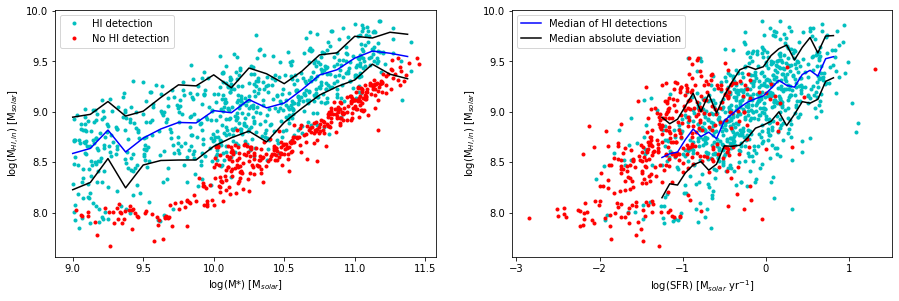

In [21]:
# Plotting the HI mass within the optical radius, against stellar masses and SFR
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(lgMstar1, lgMHIpredin1, 'c.', label= 'HI detection')
plt.plot(lgMstar2, lgMHIpredin2, 'r.', label= 'No HI detection')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI, in}$) [M$_{solar}$]')
plt.plot(INbins[:-2], INmHI1[:-2], 'b-')
plt.plot(INbins[:-2], INpMAD1[:-2], 'k-')
plt.plot(INbins[:-2], INnMAD1[:-2], 'k-')
plt.legend(loc='upper left');

plt.subplot(222)
plt.plot(np.log10(SFR_best1), lgMHIpredin1, 'c.')
plt.plot(np.log10(SFR_best2), lgMHIpredin2, 'r.')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')
plt.ylabel('log(M$_{HI, in}$) [M$_{solar}$]')
plt.plot(INbins2[:-2], INmHI2[:-2], 'b-', label = 'Median of HI detections')
plt.plot(INbins2[:-2], INpMAD2[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(INbins2[:-2], INnMAD2[:-2], 'k-')
plt.legend(loc='upper left');

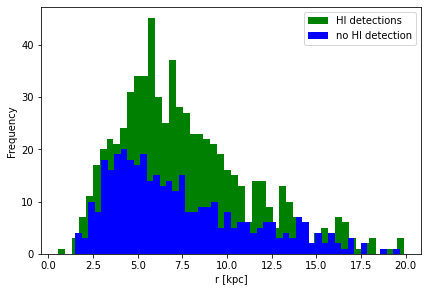

In [22]:
# Historgram plots to determine the how the investigated galaxies are distributed
plt.figure(figsize = (15,10))
plt.subplot(222)
plt.hist(r1, bins = 50, color = 'g', label = 'HI detections')
plt.hist(r2, bins = 50, color = 'b', label = 'no HI detection')
plt.xlabel('r [kpc]')
plt.ylabel('Frequency')
plt.legend(loc= 'upper right');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log10


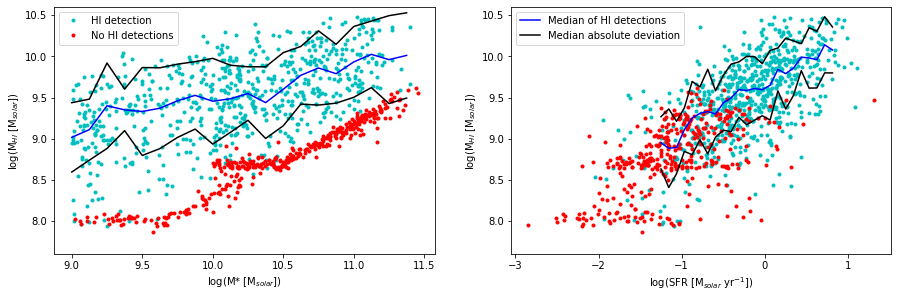

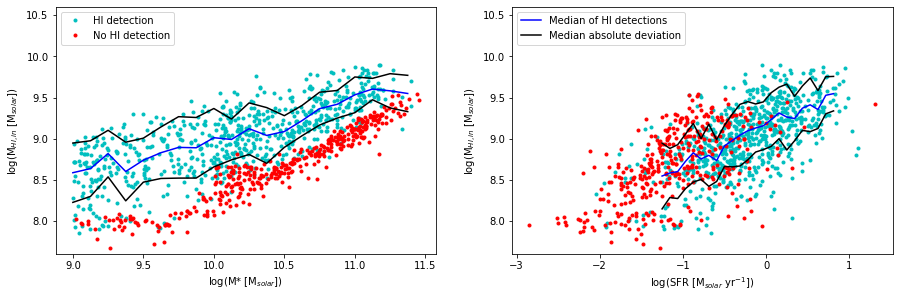

In [23]:
# Global HI mass and HI mass contained in the optical regions with median lines
plt.figure(figsize = (15,10))

plt.subplot(221)
plt.plot(lgMstar1, lgMHI1, 'c.', label= 'HI detection')
plt.plot(lgMstar2, lgMHI2, 'r.', label= 'No HI detections')
plt.plot(bins[:-2], mHIa[:-2], 'b-')
plt.plot(bins[:-2], pMAD1[:-2], 'k-')
plt.plot(bins[:-2], nMAD1[:-2], 'k-')
plt.xlabel('log(M* [M$_{solar}$])')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])')
plt.legend(loc='upper left')
plt.ylim(7.6, 10.6);

plt.subplot(222)
plt.plot(np.log10(SFR_best1), lgMHI1, 'c.')
plt.plot(np.log10(SFR_best2), lgMHI2, 'r.')
plt.plot(bins2[:-2], mHIb[:-2], 'b-', label = 'Median of HI detections')
plt.plot(bins2[:-2], pMAD2[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(bins2[:-2], nMAD2[:-2], 'k-')
plt.xlabel('log(SFR [M$_{solar}$ yr$^{-1}$])')
plt.ylabel('log(M$_{HI}$ [M$_{solar}$])')
plt.legend(loc='upper left')
plt.ylim(7.6, 10.6);

# Plotting the HI mass within the optical radius, against stellar masses and SFR
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(lgMstar1, lgMHIpredin1, 'c.', label= 'HI detection')
plt.plot(lgMstar2, lgMHIpredin2, 'r.', label= 'No HI detection')
plt.xlabel('log(M* [M$_{solar}$])')
plt.ylabel('log(M$_{HI, in}$ [M$_{solar}$])')
plt.plot(INbins[:-2], INmHI1[:-2], 'b-')
plt.plot(INbins[:-2], INpMAD1[:-2], 'k-')
plt.plot(INbins[:-2], INnMAD1[:-2], 'k-')
plt.legend(loc='upper left')
plt.ylim(7.6, 10.6);

plt.subplot(222)
plt.plot(np.log10(SFR_best1), lgMHIpredin1, 'c.')
plt.plot(np.log10(SFR_best2), lgMHIpredin2, 'r.')
plt.xlabel('log(SFR [M$_{solar}$ yr$^{-1}$])')
plt.ylabel('log(M$_{HI, in}$ [M$_{solar}$])')
plt.plot(INbins2[:-2], INmHI2[:-2], 'b-', label = 'Median of HI detections')
plt.plot(INbins2[:-2], INpMAD2[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(INbins2[:-2], INnMAD2[:-2], 'k-')
plt.legend(loc='upper left')
plt.ylim(7.6, 10.6);

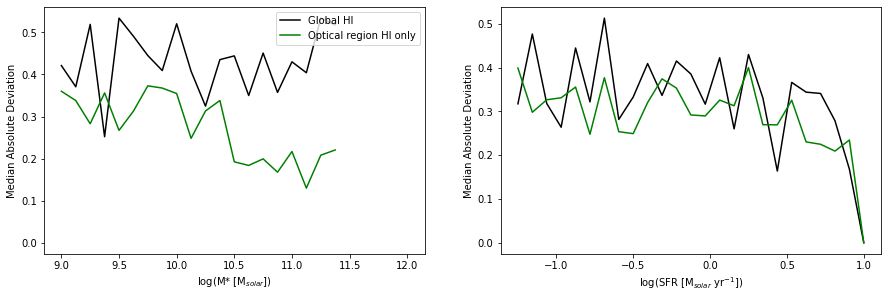

In [24]:
# To see if the removal of the optical region has improved the correlation of the plots
# We can plot the median absolute deviation (MAD) for the total HI mass per galaxy and the HI mass inside the optical region of each galaxy
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(bins, MAD1, 'k-', label= 'Global HI')
plt.plot(INbins, INMAD1, 'g-', label= 'Optical region HI only')
plt.xlabel('log(M* [M$_{solar}$])')
plt.ylabel('Median Absolute Deviation')
plt.legend(loc='upper right')

plt.subplot(222)
plt.plot(bins2, MAD2, 'k-')
plt.plot(INbins2, INMAD2, 'g-')
plt.xlabel('log(SFR [M$_{solar}$ yr$^{-1}$])')
plt.ylabel('Median Absolute Deviation');

In [27]:
# Another definition of the optical region of a galaxy would be to take the effective radius and double it
# The effective radius is the radius enclosing 50% of the emitted light of a galaxy, in the r-band this would be 50% of the optical light
# Using the xGASS decomposition data from Cook et al 2019 we can use the effective radius in the r-band of the disk of a galaxy rather than the whole galaxy radius
# Reading into python the FITS file for the xGASS decomposition
hdulist = fits.open('xGASS_Decomposition_Catalogue_11-05-2020.fits')
hdu = hdulist[1].data
cols = hdulist[1].columns
reD_r = hdu['reD_r']
effradD = np.delete(reD_r, np.where((HI_FLAG > 1) & (HI_FLAG < 90)))